# Airbnb - Data Cleaning

This file extracts relevant information from the Airbnb data file.

It saves the subset file to disk to be shared amongst other notebooks.

In [1]:
# These configurations expand the Jupyter notebook 
# They also control how much output can be displayed for each cell
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 30)
pd.set_option('display.max_colwidth', 20)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import necessary python packages
from os import listdir
from os.path import join as pjoin
import pandas as pd
from time import time, sleep
import dateutil.parser
import re

import seaborn as sns
sns.set(style='whitegrid')

# Import utilities
from Utils.DataUtils import *
from Utils.UtilsViz import *

---------------------------------------------------------------------------------------------------------------

In [3]:
data_path = "./data"
data = pjoin(data_path, 'listings.csv')
listings = pd.read_csv(data, index_col="id")
display(listings.head())

,listing_url,scrape_id,last_scraped,name,summary,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,
2539,https://www.airb...,20190708031610,2019-07-09,Clean & quiet ap...,Renovated apt ho...,...,6,0,5,1,0.21
2595,https://www.airb...,20190708031610,2019-07-09,Skylit Midtown C...,Find your romant...,...,2,1,0,1,0.38
3647,https://www.airb...,20190708031610,2019-07-08,THE VILLAGE OF H...,NaN,...,1,0,1,0,NaN
3831,https://www.airb...,20190708031610,2019-07-09,Cozy Entire Floo...,Urban retreat: e...,...,1,1,0,0,4.64
5022,https://www.airb...,20190708031610,2019-07-08,Entire Apt: Spac...,NaN,...,1,1,0,0,0.10


In [4]:
# Define some helper functions and variables for later use.
def drop_collist(df, collist):
    for c in collist:
        if c in df.columns:
            df.drop(c, inplace=True, axis=1)
    return df

def clean_number(v):
    if v != v:
        return np.nan
    v = float(re.sub("[^0-9.]", "", v))
    return v

In [5]:
# there are quite a few columns that contain only metadata
# Put the names of these columns into a list to separate them and drop them later
cols_to_drop = \
['listing_url','scrape_id', 'last_scraped','experiences_offered', 'thumbnail_url', 
 'medium_url', 'picture_url', 'xl_picture_url', 'host_id',
   'host_url', 'host_name', 'host_acceptance_rate', 
 'host_thumbnail_url', 'host_picture_url', 'street', 'license']

# Let's make a list of all the columns that contain text data
text_cols = \
['jurisdiction_names', 'notes','interaction', 'access', 'house_rules', 'neighborhood_overview', 
 'host_about', 'transit', 'space', 'summary', 'name', 'description']

In [6]:
# Get a list of all the columns we would like to keep and clean
cols_to_ignore = text_cols + cols_to_drop
cols_to_keep = [c for c in listings.columns if c not in cols_to_ignore]

## Visualize information about missing values

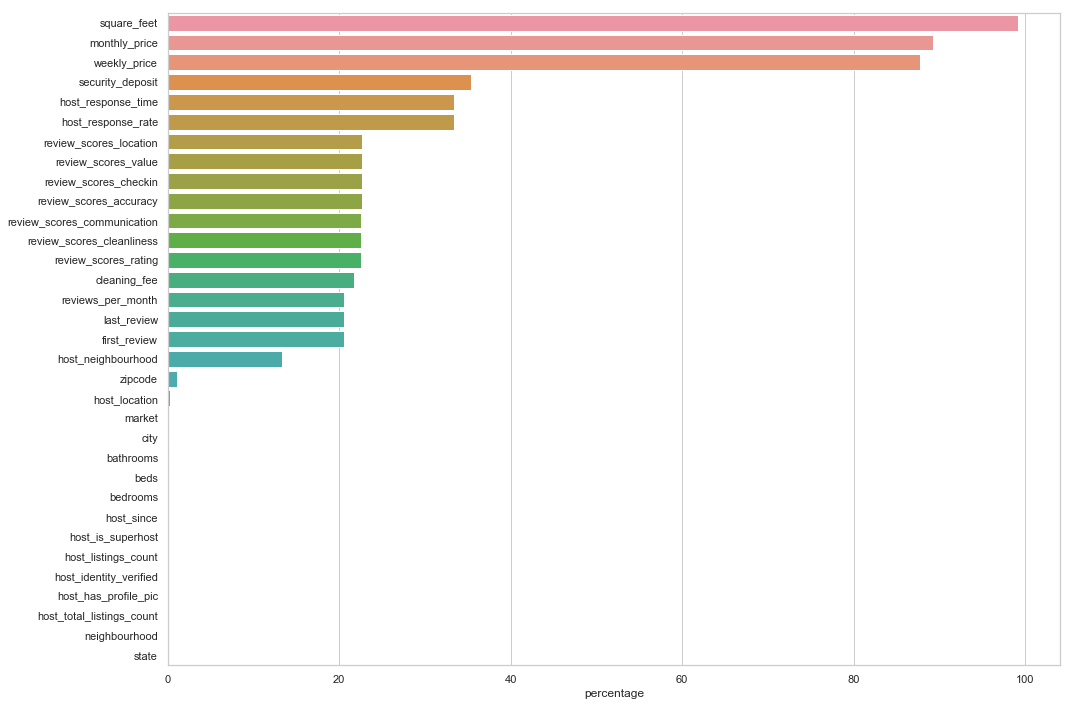

In [7]:
nan_df = analyse_nans(listings[cols_to_keep])
nan_df_t = nan_df.T
nan_df_t.sort_values(by="percentage", inplace=True, ascending=False)
nan_df_t = nan_df_t[nan_df_t["percentage"]!=0]
f, ax = plt.subplots(1,1,figsize=(16,12))
g = sns.barplot(y=nan_df_t.index, x=nan_df_t.percentage, ax=ax)

We can tackle these columns by addressing them one group at a time.

---------------

# Price

Let's start cleaning the data by formatting the price information into something usable.

In [8]:
listings["price"] = listings["price"].apply(clean_number)

Amongst the rest of the columns. Several columns need not have a direct impact on the business model. 

We will clean the key players first, and then proceed to the remaining columns

# Key columns required for analysis

## Columns that are 20-40% empty

In [9]:
# Get a subset of all the columns that have 2-40% missing values
cols_20_40 = nan_df_t[nan_df_t["percentage"].between(20,40)].index
display(
    analyse_nans(listings[cols_20_40]).iloc[:2,:],
    listings[cols_20_40].head()
)

,security_deposit,host_response_time,host_response_rate,review_scores_location,review_scores_value,...,review_scores_rating,cleaning_fee,reviews_per_month,last_review,first_review
total,17317,16361,16361,11082,11080,...,11022,10645,10052,10052,10052
percentage,35.417,33.461,33.461,22.665,22.661,...,22.542,21.771,20.558,20.558,20.558


,security_deposit,host_response_time,host_response_rate,review_scores_location,review_scores_value,...,review_scores_rating,cleaning_fee,reviews_per_month,last_review,first_review
id,,,,,,,,,,,
2539,$100.00,within an hour,100%,10.0,10.0,...,98.0,$25.00,0.21,2018-10-19,2015-12-04
2595,$350.00,within a few hours,87%,10.0,9.0,...,95.0,$100.00,0.38,2019-05-21,2009-11-21
3647,$200.00,within a day,100%,NaN,NaN,...,NaN,$75.00,NaN,NaN,NaN
3831,$500.00,within a few hours,93%,10.0,9.0,...,90.0,NaN,4.64,2019-07-05,2014-09-30
5022,$100.00,NaN,NaN,9.0,10.0,...,93.0,$80.00,0.10,2018-11-19,2012-03-20


### cleaning_fee

Cleaning Fee can translate into maintainence costs down the line for property. 

Let's first format the information so that it is easily digestible.

In [10]:
listings["cleaning_fee"] = listings["cleaning_fee"].apply(clean_number)

In [11]:
listings["cleaning_fee"].head()

id
2539     25.0
2595    100.0
3647     75.0
3831      NaN
5022     80.0
Name: cleaning_fee, dtype: float64

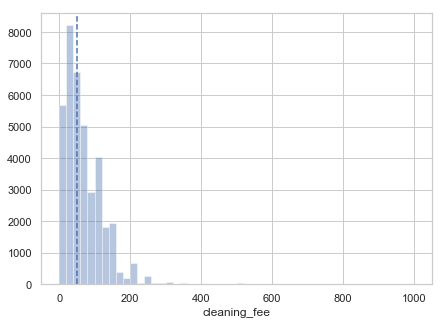

In [12]:
f, ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["cleaning_fee"].dropna(), ax=ax, kde=False)
l = ax.axvline(x=listings["cleaning_fee"].median(), linestyle="--")

The cleaning fee is fairly common, and a right skewed distribution.

Fill the cleaning fee with the median value

In [13]:
listings["cleaning_fee"] = listings["cleaning_fee"].fillna(listings["cleaning_fee"].median())

### 	security_deposit

Security deposits are essentially additional (recoverable) costs that a customer has to incurr.

This information may have a role in deciding pricing of a listing.

In [14]:
listings["security_deposit"] = listings["security_deposit"].apply(clean_number)

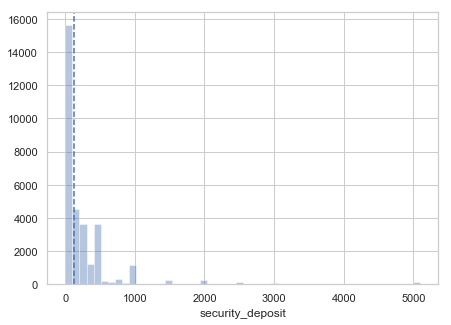

In [15]:
f, ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["security_deposit"].dropna(), ax=ax, kde=False)
l = ax.axvline(x=listings["security_deposit"].median(), linestyle="--")

Most listings do not seem to request a security deposit

It may be prudent to fill the missing values of security deposit with 0

In [16]:
listings["security_deposit"] = listings["security_deposit"].fillna(0)

-------------------

## Columns that are 0-20% empty

In [17]:
cols_20 = nan_df_t[nan_df_t["percentage"]<=20].index
display(
    analyse_nans(listings[cols_20]).iloc[:2,:],
    listings[cols_20].head()
)

,host_neighbourhood,zipcode,host_location,market,city,...,host_identity_verified,host_has_profile_pic,host_total_listings_count,neighbourhood,state
total,6529,517,164,109,62,...,21,21,21,12,6
percentage,13.353,1.057,0.335,0.223,0.127,...,0.043,0.043,0.043,0.025,0.012


,host_neighbourhood,zipcode,host_location,market,city,...,host_identity_verified,host_has_profile_pic,host_total_listings_count,neighbourhood,state
id,,,,,,,,,,,
2539,Gravesend,11218,"New York, New Yo...",New York,Brooklyn,...,t,t,6.0,Brooklyn,NY
2595,Midtown,10018,"New York, New Yo...",New York,New York,...,t,t,5.0,Manhattan,NY
3647,Harlem,10027,"New York, New Yo...",New York,New York,...,t,t,1.0,Harlem,NY
3831,Clinton Hill,11238,"New York, New Yo...",New York,Brooklyn,...,t,t,1.0,Brooklyn,NY
5022,East Harlem,10029,"Miami, Florida, ...",New York,New York,...,t,t,1.0,East Harlem,NY


### extra_people

In [18]:
listings["extra_people"] = listings["extra_people"].apply(clean_number)

### neighbourhood

In [19]:
q = "neighbourhood!=neighbourhood"
analyse_nans(listings[["neighbourhood_cleansed", "neighbourhood"]])
# It might be safer to fill the neighborhood column with missing values from the neighborhood_cleansed column
listings["neighbourhood"] = listings["neighbourhood"].fillna(listings["neighbourhood_cleansed"])

###  city

In [20]:
q = "city != city"
# Let's look at the top 10 most common entries in this field
city_vcs = listings["city"].value_counts()
display(city_vcs[:10])

New York            21934
Brooklyn            18978
Queens               4328
Bronx                 773
Brooklyn              694
Staten Island         346
The Bronx             213
Astoria               146
Long Island City       81
New York               81
Name: city, dtype: int64

In [21]:
# It may be a safe bet to fill the remaining missing values as the most occuring value
listings["city"].fillna(city_vcs.index[0], inplace=True)

### bedrooms

We can fill the number of bedrooms with 0

In [22]:
listings["bedrooms"] = listings["bedrooms"].fillna(0)

###  beds

In [23]:
print("Number of missings rows for beds :", listings.query("beds!=beds").shape[0])

Number of missings rows for beds : 40


In [24]:
# We can fill the number of missing beds as equal to the number of bedrooms present.
# If no bedrooms are specified, then fill beds as 0
listings["beds"] = listings["beds"].fillna(listings["bedrooms"])

###  bathrooms

In [25]:
print("Number of missings rows for bathrooms :", listings.query("bathrooms!=bathrooms").shape[0])

Number of missings rows for bathrooms : 56


In [26]:
listings["bathrooms"] = listings["bathrooms"].fillna(1)

### zipcode

In [27]:
q = "zipcode!=zipcode"
listings.query(q).shape

(517, 105)

Zipcode is generally a powerful feature, and imputing missing zipcode values incorrectly may have adverse effects on analysis and modeling.

To that end, we will remove those rows where the zipcode is missing.

In [28]:
listings.dropna(subset=['zipcode'], inplace=True)

In [29]:
analyse_nans(listings[cols_20])

,host_neighbourhood,zipcode,host_location,market,city,...,host_identity_verified,host_has_profile_pic,host_total_listings_count,neighbourhood,state
total,6090,0,164,109,0,...,21,21,21,0,4
percentage,12.588,0,0.339,0.225,0,...,0.043,0.043,0.043,0,0.008
idx_list,"[100184, 214917,...",[],"[100184, 1449546...","[12895146, 12914...",[],...,"[100184, 1449546...","[100184, 1449546...","[100184, 1449546...",[],"[391948, 2845844..."


### state 

In [30]:
q = "state!=state"
listings["state"].value_counts()

NY           48359
Ny               6
ny               3
CA               2
NJ               2
MP               1
New York         1
Name: state, dtype: int64

We do not need this column. But it seems there are some rows that we may need to drop. 
Once these rows are removed, we can drop the column

In [31]:
# There seem to be some rows where the state is not in NY.
# We can remove these rows
wrong_states = ["CA","NJ","MP"]
wrong_state_indices = listings[listings["state"].isin(wrong_states)].index.values
for idx in wrong_state_indices:
    if idx in listings.index.values:
        listings.drop(idx, axis=0, inplace=True)
        
# listings = drop_collist(listings, ["state"])

# Other columns

These need not have a direct influence on price.

However it may be prudent that they are cleaned for posterity.

### host_response_time

In [32]:
analyse_nans(listings[["host_response_time"]]).iloc[:2]

,host_response_time
total,16117
percentage,33.318


In [33]:
listings["host_response_time"].value_counts()

within an hour        18791
within a few hours     7687
within a day           4780
a few days or more      998
Name: host_response_time, dtype: int64

Rather than biasing any category, it my be prudent to fill this column with a separate category instead

In [34]:
listings["host_response_time"].fillna("XX", inplace=True)

### host_response_rate

In [35]:
listings["host_response_rate"] = listings["host_response_rate"].apply(clean_number)

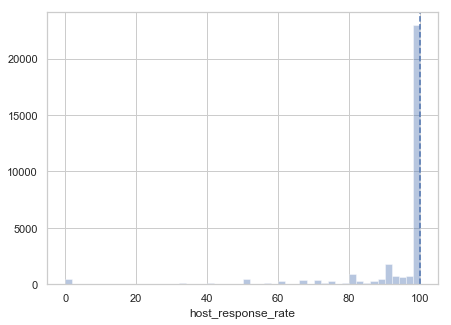

In [36]:
f, ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["host_response_rate"].dropna(), ax=ax, kde=False)
l = ax.axvline(x=listings["host_response_rate"].median(), linestyle="--")

It would seem most hosts do respond. So we can fill this with the most occuring value

In [37]:
hrr_vcs= listings["host_response_rate"].value_counts()
listings["host_response_rate"].fillna(hrr_vcs.index[0], inplace=True)

### Reviews

In [38]:
all_review_cols = [c for c in cols_20_40 if "review" in c]
analyse_nans(listings[all_review_cols])

,review_scores_location,review_scores_value,review_scores_checkin,review_scores_accuracy,review_scores_communication,review_scores_cleanliness,review_scores_rating,reviews_per_month,last_review,first_review
total,10952,10950,10948,10930,10925,10913,10892,9931,9931,9931
percentage,22.641,22.637,22.632,22.595,22.585,22.56,22.517,20.53,20.53,20.53
idx_list,"[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870...","[3647, 7750, 870..."


In [39]:
review_scores_cols = [c for c in all_review_cols if "review_" in c]

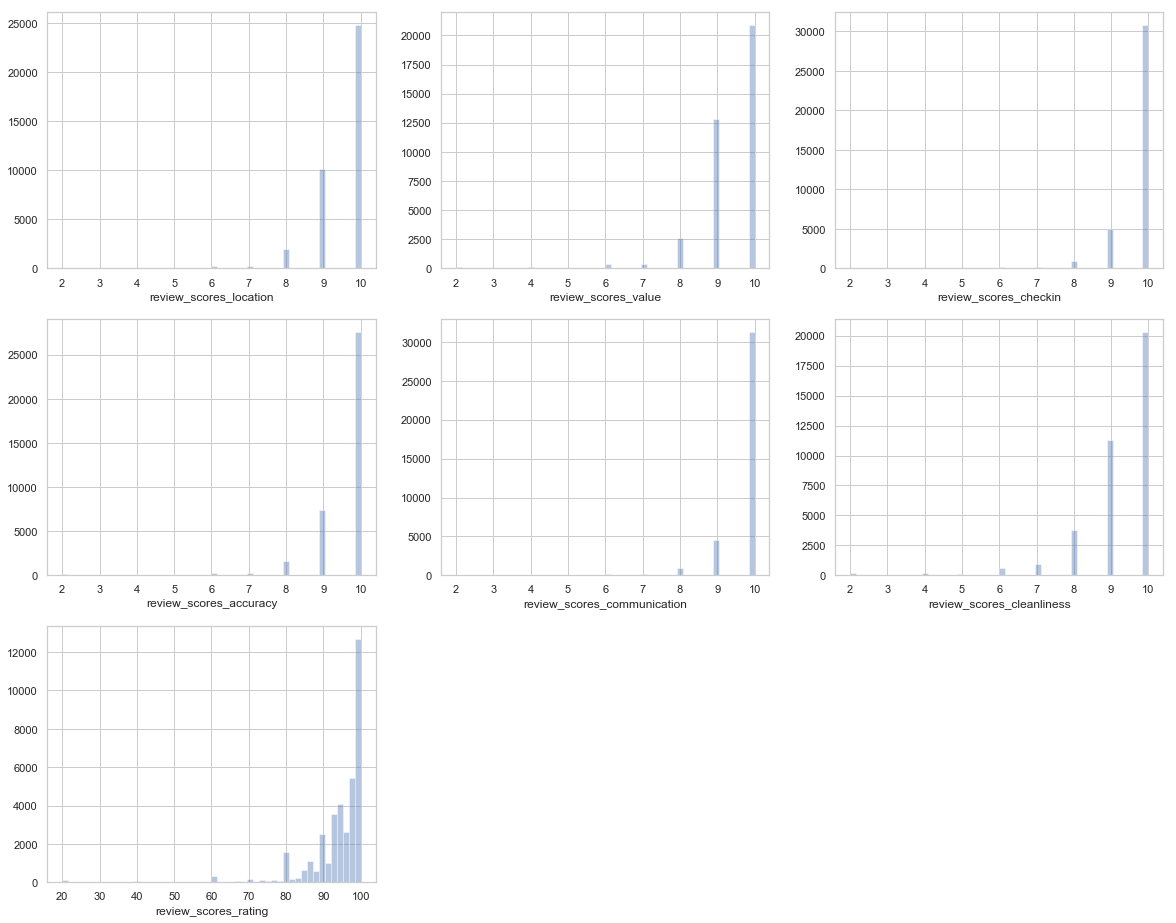

In [40]:
f, ax = plt.subplots(3,3, figsize=(20,16))
col_counter = 0
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[0][0], kde=False)
col_counter+=1
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[0][1], kde=False)
col_counter+=1
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[0][2], kde=False)
col_counter+=1
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[1][0], kde=False)
col_counter+=1
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[1][1], kde=False)
col_counter+=1
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[1][2], kde=False)
col_counter+=1
g = sns.distplot(a=listings[~listings[review_scores_cols[col_counter]].isna()][review_scores_cols[col_counter]], ax=ax[2][0], kde=False)
col_counter+=1
ax[2][1].set_visible(not ax[2][1].get_visible())
ax[2][2].set_visible(not ax[2][2].get_visible())

In [41]:
for c in review_scores_cols:
    print(c, "median :", listings[c].median())

review_scores_location median : 10.0
review_scores_value median : 10.0
review_scores_checkin median : 10.0
review_scores_accuracy median : 10.0
review_scores_communication median : 10.0
review_scores_cleanliness median : 10.0
review_scores_rating median : 96.0


We can just fill the missing values with the median

In [42]:
for c in review_scores_cols:
    listings[c].fillna(listings[c].median(), inplace=True)

### Reviews per month

Median reviews per month : 0.72


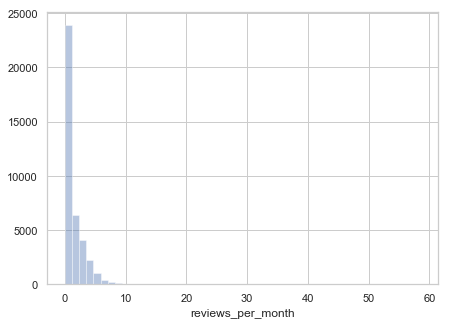

In [43]:
f, ax = plt.subplots(1,1,figsize=(7,5))
g = sns.distplot(listings["reviews_per_month"].dropna(), ax=ax, kde=False)
print("Median reviews per month :", listings["reviews_per_month"].median())

We can fill the number of reviews per month with the median value

In [44]:
listings["reviews_per_month"].fillna(listings["reviews_per_month"].median(), inplace=True)

### first_review and last_review

Let's first check the hypothesis that if the first review date is missing, would the corresponding last_review date be also missing (and vice versa)?

In [45]:
review_date_cols = ["first_review", "last_review"]

# Verify that these columns have missing values in the exact same rows.
print("Number of rows between pairs of columns that have NaNs only in one of them - ")
for i in range(1, len(review_date_cols)):
    print(review_date_cols[i], "\t", review_date_cols[i-1], end=" -->\t ")
    idx1 = nan_df[review_date_cols[i-1]].iloc[2]
    idx2 = nan_df[review_date_cols[i]].iloc[2]
    l = find_unique_elems([idx1, idx2])
    print(len(l), "rows, \ti.e.", round(100*len(l)/listings.shape[0], 2), "% of total listings rows")

Number of rows between pairs of columns that have NaNs only in one of them - 
last_review 	 first_review -->	 0 rows, 	i.e. 0.0 % of total listings rows


In [46]:
# Let's make some additional helper columns
listings['last_review'] = pd.to_datetime(listings['last_review'])
listings['lreview_year'] = listings['last_review'].dt.year
listings['lreview_month'] = listings['last_review'].dt.month
listings['lreview_day'] = listings['last_review'].dt.day

listings['first_review'] = pd.to_datetime(listings['first_review'])
listings['freview_year'] = listings['first_review'].dt.year
listings['freview_month'] = listings['first_review'].dt.month
listings['freview_day'] = listings['first_review'].dt.day

When were the reviews posted? 

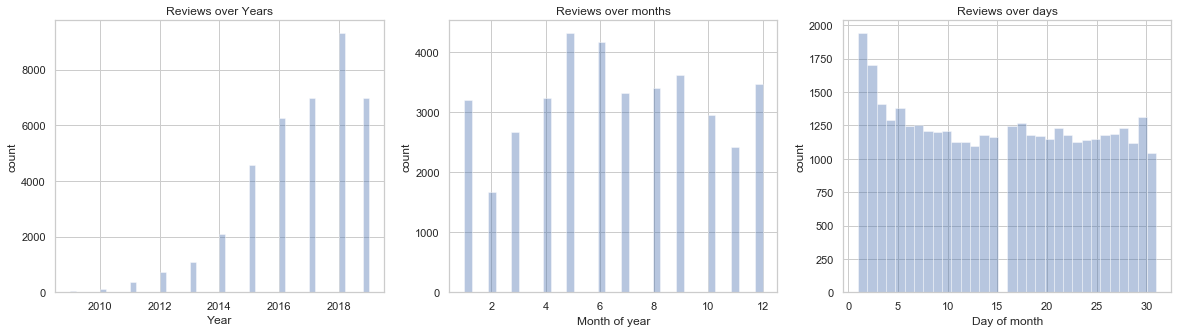

In [47]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))
g = sns.distplot(a=listings[~listings["freview_year"].isna()]["freview_year"], ax=ax[0], kde=False)
g = g.set(title="Reviews over Years", xlabel="Year", ylabel="count")
g = sns.distplot(a=listings[~listings["freview_month"].isna()]["freview_month"], ax=ax[1], kde=False)
g = g.set(title="Reviews over months", xlabel="Month of year", ylabel="count")
g = sns.distplot(a=listings[~listings["freview_day"].isna()]["freview_day"], ax=ax[2], kde=False)
g = g.set(title="Reviews over days", xlabel="Day of month", ylabel="count")

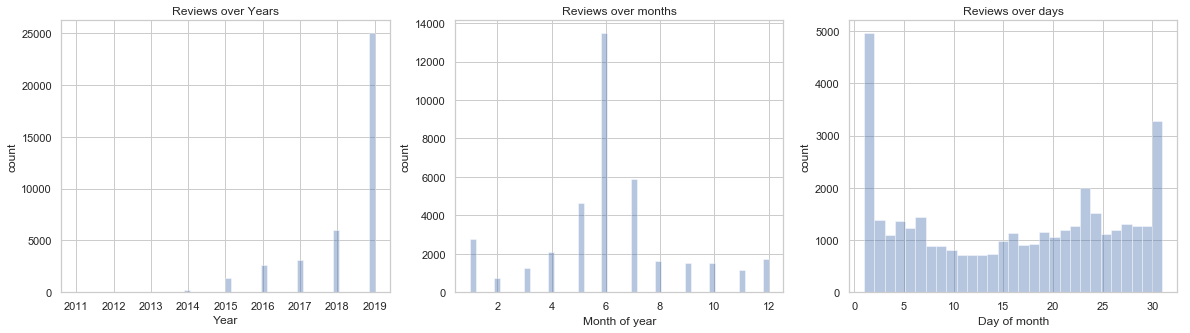

In [48]:
f, ax = plt.subplots(1, 3, figsize=(20, 5))
g = sns.distplot(a=listings[~listings["lreview_year"].isna()]["lreview_year"], ax=ax[0], kde=False)
g = g.set(title="Reviews over Years", xlabel="Year", ylabel="count")
g = sns.distplot(a=listings[~listings["lreview_month"].isna()]["lreview_month"], ax=ax[1], kde=False)
g = g.set(title="Reviews over months", xlabel="Month of year", ylabel="count")
g = sns.distplot(a=listings[~listings["lreview_day"].isna()]["lreview_day"], ax=ax[2], kde=False)
g = g.set(title="Reviews over days", xlabel="Day of month", ylabel="count")

If we use median, we can estimate that the missing year values is (most probably) 2018, the missing month values is (most probably) 10/11 and for date would be around 16.

Or we can create a separate category called X for each column, to estimate that there has been no review written for those dates yet.Upon checking online using the URLs provided, we can verify that no reviews are provided for those listings yet. 

The latter method is used for imputation here.

In [49]:
listings["first_review"].fillna("XX", inplace=True)
listings["last_review"].fillna("XX", inplace=True)
listings['lreview_year'].fillna(0, inplace=True)
listings['lreview_month'].fillna(0, inplace=True)
listings['lreview_day'].fillna(0, inplace=True)
listings['freview_year'].fillna(0, inplace=True)
listings['freview_month'].fillna(0, inplace=True)
listings['freview_day'].fillna(0, inplace=True)

### host_total_listings_count, host_listings_count

Both the listings count and total listings count are missing values at the same row locations.

In [50]:
id_list = [nan_df["host_listings_count"].loc["idx_list"], nan_df["host_total_listings_count"].loc["idx_list"]]
find_unique_elems(id_list)

[]

They can be filled with the number of occurences of their respective hosts

In [51]:
id_vcs = listings["host_id"].value_counts()
id_vcs.head()

219517861    327
107434423    232
30283594     121
137358866    103
12243051      96
Name: host_id, dtype: int64

In [52]:
q = "host_listings_count!=host_listings_count"
def fill_listings_count(row):
    if row["host_listings_count"] == row["host_listings_count"]:
        return row
    if row["host_id"] in id_vcs.index:
        val = id_vcs[row["host_id"]]
        row["host_listings_count"] = val
        row["host_total_listings_count"] = val
    else:
        row["host_listings_count"] = 1
        row["host_total_listings_count"] = 1
    return row
listings = listings.apply(fill_listings_count, axis=1)

### host_has_profile_pic

In [53]:
# The presence of a profile pic can have influence on whether a listing gets booked.
# We can fill the missing value with False
listings["host_has_profile_pic"] = listings["host_has_profile_pic"].fillna("f")

### host_identity_verified

In [54]:
# The presence of a verification can have influence on whether a listing gets booked.
# We can fill the missing value with False
listings["host_has_profile_pic"] = listings["host_has_profile_pic"].fillna("f")

### host_is_superhost

In [55]:
listings["host_is_superhost"] = listings["host_is_superhost"].fillna("f")

### host_since

We can fill the host since date with calendar last scraped.

In [56]:
listings["host_since"] = listings["host_since"].fillna(listings["calendar_last_scraped"])

### host_location

We can fill the host location with the most occuring host location

In [57]:
hl_vcs = listings["host_location"].value_counts()
listings["host_location"] = listings["host_location"].fillna(hl_vcs.index[0])

### host_neighbourhood

In [58]:
display(listings[["host_neighbourhood", "neighbourhood_cleansed"]].head())
# We can fill the host neighborhood with the neighborhood cleansed column

,host_neighbourhood,neighbourhood_cleansed
id,,
2539,Gravesend,Kensington
2595,Midtown,Midtown
3647,Harlem,Harlem
3831,Clinton Hill,Clinton Hill
5022,East Harlem,East Harlem


In [59]:
listings["host_neighbourhood"] = listings["host_neighbourhood"].fillna(listings["neighbourhood_cleansed"])

### market

We can fill the market with the most occuring market

In [61]:
market_vcs = listings["market"].value_counts()
listings["market"] = listings["market"].fillna(market_vcs.index[0])

-------------

# Selecting a subset of the dataframe

Finally,drop all the unnecessary columns 

In [62]:
listings = listings[cols_to_keep]
# Drop all the columns that have had 80% and above missing values.
# And also drop the "state" column
drop_c = list(nan_df_t[nan_df_t["percentage"]>=80].index) + ["state"]
listings = drop_collist(listings, drop_c)

Quick verification to see that there are no more missing values

In [63]:
print("Maximum number of missing values :", analyse_nans(listings).iloc[1].max())

Maximum number of missing values : 0.0


In [64]:
# Save the file to disk
listings.to_csv("./listings_cleaned.csv")